## Carribean image parsing and conversion

In [1]:
import os
import tarfile
import rasterio
from rasterio.plot import reshape_as_image
from rasterio.mask import mask
from rasterio.features import rasterize
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import mapping
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

#sns.set()
%matplotlib inline

# contest df load
meta = pd.read_csv("metadata.csv")
train_labels = pd.read_csv("train_labels.csv")
submission = pd.read_csv("submission_format.csv")

# tiff and geojson file paths

train_tiff_paths = meta.image.values
test_tiff_paths = train_tiff_paths[[0, 1, 3, 5, 6]]
train_geo_paths = meta.train.values
test_geo_paths = meta.test.dropna().values

#extracting stac from .tar file

stac_tar = tarfile.open("stac.tar", mode = "r")
stac_tar.extract("stac")

#checking function worked- stac is in wd

os.listdir("stac")

['catalog.json', 'colombia', 'guatemala', 'st_lucia']

### Sample image review and visualization

In [43]:
mixco_1_geometries = gpd.read_file(train_geo_paths[0])
mixco_1_geometries = mixco_1_geometries.to_crs(crs = {"init" : "EPSG:32616"})

np.random.seed(1017)
rand_int = np.random.randint(0, len(mixco_1_geometries))
coord = mapping(mixco_1_geometries)["features"][rand_int]["geometry"]
coord

{'type': 'Polygon',
 'coordinates': (((113724.59045496018, 1619555.9661074025),
   (113724.00538267446, 1619556.2782596608),
   (113724.86655906442, 1619558.925470079),
   (113730.88671938097, 1619558.4694660774),
   (113730.31938694802, 1619555.7155896805),
   (113724.59045496018, 1619555.9661074025)),)}

Image roof type: concrete_cement


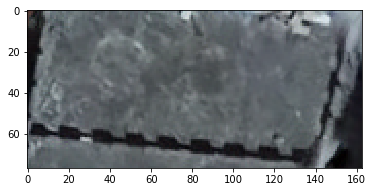

In [44]:
PADDING = 1
mixco_1_tiff = rasterio.open(train_tiff_paths[0])

masked_image, out_transform = mask(mixco_1_tiff, [coord], 
                                   crop = True, 
                                   pad = True,
                                   filled = False, 
                                   pad_width = PADDING)
roof_image = reshape_as_image(masked_image)
roof_image = cv2.cvtColor(roof_image, cv2.COLOR_RGB2BGR)

print("Image roof type:", mixco_1_geometries.iloc[rand_int].roof_material)
plt.imshow(roof_image);

### Geometry parse

In [198]:
train_epsg = ["EPSG:32616", "EPSG:32616", "EPSG:32620", "EPSG:32620", "EPSG:32620", "EPSG:32618", "EPSG:32618"]
train_places = ["Guat_mixco_1", "Guat_mixco_3", "St_Lucia_castries", "St_Lucia_dennery", "St_Lucia_gros",
                "Colombia_rural", "Colombia_soacha"]

test_epsg = ["EPSG:32616", "EPSG:32616", "EPSG:32620", "EPSG:32618", "EPSG:32618"]
test_places = ["Guat_mixco_1", "Guat_mixco_3", "St_Lucia_dennery", "Colombia_rural", "Colombia_soacha"]

def geometry_parse(epsg_list, paths, places, tiff, set):
    
    set_geometries = pd.DataFrame()
    
    for num, epsg in enumerate(epsg_list):
        print("Starting loop for {} {}, iteration {}".format(set, epsg, num + 1))
        roof_geometries = gpd.read_file(paths[num])
        roof_geometries = roof_geometries.to_crs(crs = {"init" : epsg})
        roof_geometries["location"] = places[num]
        roof_geometries["tiff"] = tiff[num]
        roof_geometries["set"] = str(set)
        set_geometries = pd.concat([roof_geometries, set_geometries], axis = 0)
        
    return(set_geometries)

train_geometries = geometry_parse(epsg_list = train_epsg, 
                                  paths = train_geo_paths, 
                                  places = train_places, 
                                  tiff = train_tiff_paths,
                                  set = "train")

test_geometries = geometry_parse(epsg_list = test_epsg, 
                                 paths = test_geo_paths, 
                                 places = test_places, 
                                 tiff = test_tiff_paths,
                                 set = "test")

test_geometries.head(10)

Starting loop for train EPSG:32616, iteration 1
Starting loop for train EPSG:32616, iteration 2
Starting loop for train EPSG:32620, iteration 3
Starting loop for train EPSG:32620, iteration 4
Starting loop for train EPSG:32620, iteration 5
Starting loop for train EPSG:32618, iteration 6
Starting loop for train EPSG:32618, iteration 7
Starting loop for test EPSG:32616, iteration 1
Starting loop for test EPSG:32616, iteration 2
Starting loop for test EPSG:32620, iteration 3
Starting loop for test EPSG:32618, iteration 4
Starting loop for test EPSG:32618, iteration 5


,id,geometry,location,tiff,set
0,7a4adb80,"POLYGON ((591999.684 505480.028, 592000.509 50...",Colombia_soacha,stac/colombia/borde_soacha/borde_soacha_ortho-...,test
1,7a4896cc,"POLYGON ((591972.763 505508.409, 591985.041 50...",Colombia_soacha,stac/colombia/borde_soacha/borde_soacha_ortho-...,test
2,7a518ee4,"POLYGON ((591985.180 505506.114, 591997.354 50...",Colombia_soacha,stac/colombia/borde_soacha/borde_soacha_ortho-...,test
3,7a4f767c,"POLYGON ((591974.015 505520.409, 591987.102 50...",Colombia_soacha,stac/colombia/borde_soacha/borde_soacha_ortho-...,test
4,7a48f9fa,"POLYGON ((591992.693 505516.861, 591999.270 50...",Colombia_soacha,stac/colombia/borde_soacha/borde_soacha_ortho-...,test
5,7a472206,"POLYGON ((591952.625 505501.001, 591965.804 50...",Colombia_soacha,stac/colombia/borde_soacha/borde_soacha_ortho-...,test
6,7a4c7a76,"POLYGON ((591958.885 505541.278, 591965.165 50...",Colombia_soacha,stac/colombia/borde_soacha/borde_soacha_ortho-...,test
7,7a512404,"POLYGON ((591950.120 505483.054, 591956.178 50...",Colombia_soacha,stac/colombia/borde_soacha/borde_soacha_ortho-...,test
8,7a4b64ce,"POLYGON ((591975.685 505483.262, 591980.797 50...",Colombia_soacha,stac/colombia/borde_soacha/borde_soacha_ortho-...,test
9,7a510992,"POLYGON ((591976.833 505495.471, 591983.353 50...",Colombia_soacha,stac/colombia/borde_soacha/borde_soacha_ortho-...,test


In [95]:
# values match numbers given by competition page

pd.DataFrame({
    "train_roof_n": train_geometries["roof_material"].value_counts(),
    "train_roof_percent": train_geometries["roof_material"].value_counts(normalize = True),
    "test_roof_n": test_geometries["roof_material"].value_counts(),
    "test_roof_percent": test_geometries["roof_material"].value_counts(normalize = True)
})

,train_roof_n,train_roof_percent,test_roof_n,test_roof_percent
concrete_cement,1518,0.067308,1021,0.083709
healthy_metal,14817,0.656986,9273,0.760269
incomplete,669,0.029663,9,0.000738
irregular_metal,5241,0.232386,1609,0.131918
other,308,0.013657,285,0.023366


In [96]:
pd.DataFrame({
    "roof_percent_by_area": train_geometries.groupby("location")["roof_material"].value_counts(normalize = True)
})

roof_percent_by_area
location          roof_material                        
Colombia_rural    healthy_metal                0.546434
                  irregular_metal              0.345792
                  incomplete                   0.056180
                  concrete_cement              0.049759
                  other                        0.001834
Colombia_soacha   healthy_metal                0.527273
                  irregular_metal              0.354295
                  incomplete                   0.069224
                  concrete_cement              0.046706
                  other                        0.002502
Guat_mixco_1      irregular_metal              0.459564
                  healthy_metal                0.257535
                  concrete_cement              0.240525
                  other                        0.042375
Guat_mixco_3      concrete_cement              0.327044
                  healthy_metal                0.320755
                  irregular_metal              0.295597
                  other                        0.056604
St_Lucia_castries healthy_metal                0.968334
                  other                        0.016095
                  concrete_cement              0.015570
St_Lucia_dennery  healthy_metal                0.919323
                  concrete_cement              0.031873
                  irregular_metal              0.021912
                  other                        0.018924
                  incomplete                   0.007968
St_Lucia_gros     healthy_metal                0.966446
                  concrete_cement              0.021352
                  other                        0.011693
                  incomplete                   0.000508

## Geometry to image conversions

In [2]:
# adding new directory for all images

os.makedirs("C:/Users/Mark/geo_py37/all_carribean_images", exist_ok = True)

train_path = "C:/Users/Mark/geo_py37/all_carribean_images/training"
validation_path = "C:/Users/Mark/geo_py37/all_carribean_images/validation"
test_path = "C:/Users/Mark/geo_py37/all_carribean_images/testing"

os.makedirs(train_path, exist_ok = True)
os.makedirs(validation_path, exist_ok = True)
os.makedirs(test_path, exist_ok = True)

#os.listdir()

os.listdir("all_carribean_images")

['testing', 'training', 'validation']

In [239]:
validation_index = train_geometries.id.sample(frac = 0.1, replace = False, random_state = 1017)
validation_geometries = train_geometries[train_geometries.id.isin(validation_index)]
validation_geometries["set"] = "validation"
validation_geometries.reset_index(inplace = True, drop = True)
validation_labels = train_labels[train_labels.id.isin(validation_index)]
validation_labels.to_csv("validation_labels.csv")

train_geometries = train_geometries[~train_geometries.id.isin(validation_index)]
train_geometries.reset_index(inplace = True, drop = True)
train_labels = train_labels[~train_labels.id.isin(validation_index)]
train_labels.to_csv("train_labels.csv")

print("train shape:", train_geometries.shape)
print("validation shape:", validation_geometries.shape)

train shape: (20298, 7)
validation shape: (2255, 7)


C:\Users\Mark\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [177]:
def geometry_to_image(set, img_folder):
    
    image_dims = pd.DataFrame()
    
    for idx, row in set.iterrows():
        tiff = rasterio.open(row.tiff, "r")
        coord = mapping(set)["features"][idx]["geometry"]
        masked_image, out_transform = mask(tiff, [coord],
                                           crop = True, 
                                           pad = True,
                                           filled = False, 
                                           pad_width = PADDING)
        image = reshape_as_image(masked_image)
        img_path = os.path.join(img_folder, str(row.id + ".png"))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(img_path, image)

        dimensions = pd.DataFrame({
            "id": row.id,
            "width": image.shape[0],
            "height": image.shape[1],
            "channel": image.shape[2],
        }, index = [0])

        image_dims = pd.concat([dimensions, image_dims], axis = 0)
        
    return image_dims

In [178]:
train_dims = geometry_to_image(set = train_geometries,
                               img_folder = train_path)

validation_dims = geometry_to_image(set = validation_geometries,
                                    img_folder = validation_path)

test_geometries.reset_index(inplace = True, drop = True)
test_dims = geometry_to_image(set = test_geometries,
                              img_folder = test_path)

## Dimension review

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


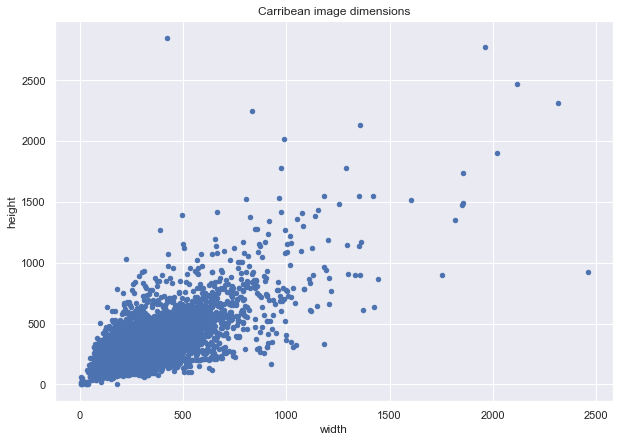

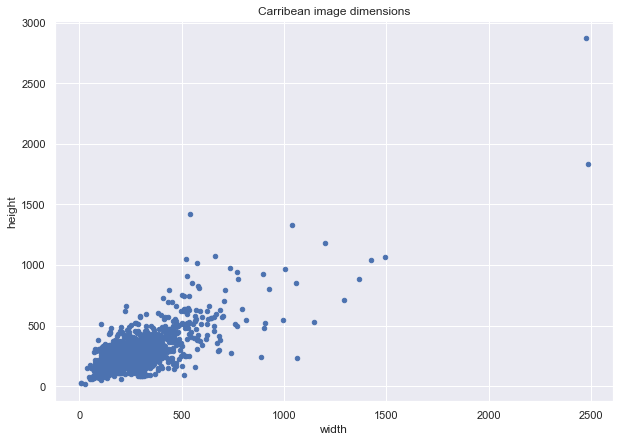

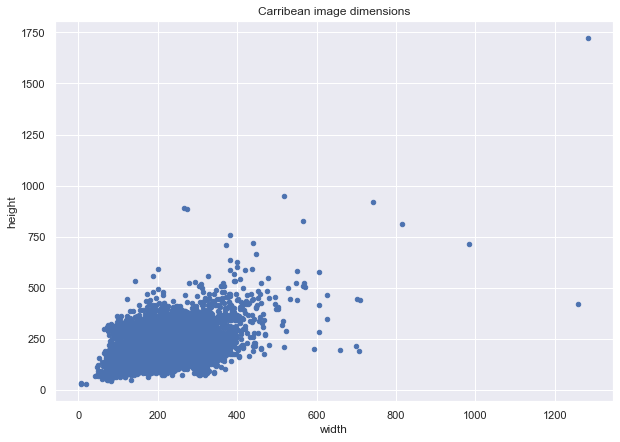

In [218]:
for set in [train_dims, validation_dims, test_dims]:
    set.plot(kind = "scatter", x = "width", y = "height", 
             title = "Carribean image dimensions", figsize = (10, 7))

In [190]:
train_dims.describe()

,width,height,channel
count,20298.000000,20298.000000,20298.0
mean,255.139176,259.463445,3.0
std,130.637552,132.146081,0.0
min,5.000000,3.000000,3.0
25%,172.000000,178.000000,3.0
50%,234.000000,242.000000,3.0
75%,310.000000,311.000000,3.0
max,2460.000000,2846.000000,3.0


In [208]:
test_dims.describe()

,width,height,channel
count,7325.000000,7325.000000,7325.0
mean,226.219522,236.248601,3.0
std,83.816898,85.550558,0.0
min,6.000000,29.000000,3.0
25%,164.000000,172.000000,3.0
50%,217.000000,232.000000,3.0
75%,288.000000,299.000000,3.0
max,1283.000000,1722.000000,3.0
